# Воспроизводим Space Colonization Algorithm (Runions et al 2007) в его самом простом виде

In [10]:
%matplotlib inline

In [11]:
import numpy as np
import random

from numpy import array, arange, zeros, ones, sin, cos, pi
from numpy import linalg

from importlib import reload
import sys

from pathlib import Path

import itertools as itt

In [12]:
from matplotlib import pyplot as plt
import matplotlib as mpl

from matplotlib.pyplot import figure, gcf, gca, plot, close, xlim, ylim, xlabel, ylabel, title,\
                              subplots
plt.style.use('seaborn-dark')

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_47099/530338419.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


In [13]:
import scipy as sp
from scipy import ndimage as ndi
from scipy import stats


In [14]:
# import plotly.express as px

In [15]:
import networkx

In [16]:
from tqdm.auto import tqdm

## How to implement attraction points?
Easiest is to have them as an array or list. This list will be updated to remove points within killing distance or may be add more points at some stage

## How to implement the TreeNodes? Let's say we want to build data representation from scratch

This in some sense is a poor man's directed graph. NetworkX can turn out to be easier to work with in the end

For a node we should be able to:
 - [X] assign a parent (single) node. Can be empty (root)
 - [X] attach a new child node. A list of child nodes can be empty (tip). 
 - [ ] follow all upstream nodes recursively (or after conversion to NetworkX, iteratively
 - [ ] follow all downstream nodes recursively or iteratively
 - [X] update the set of attraction points for which this node is the nearest (and within distance of influence)
 - [X] Plot the given node as a point and edges to all child nodes as lines. May be tuned to plot smaller point if the node is a tip 

This implementation should be minimal enough to be re-written from scratch any time.

In [17]:
# this should be converted to networkX Digraph eventually
class TreeNode:
    max_branches=5 # safety switch to prevent infinite branching
    def __init__(self, v, parent=None, tree=None):
        self.parent = parent
        self.tree = set() if tree is None else tree
        self.tree.add(self)
        if parent is not None and not self in parent.children:
            parent.children.append(self)
            
        self.children = []
        self.v = np.array(v) # spatial coordinate of the node
    
    def spawn(self, 
              S : "attractor set", 
              Dg : "growth distance" = 0.025, 
              eps=0.00001,
              jitter=0.01,
              verbose=False):
        
        if not len(S):
            return
        S = np.array(S)
        d = (S - self.v)
        
        n = np.sum(d/(1e-6 + linalg.norm(d, axis=1)[:,np.newaxis]), axis=0)
                
        nnorm = np.linalg.norm(n)            
        
        n = n / (1e-6 + nnorm)
            
        vdash = self.v + Dg*n
                
        if len(self.children) < self.max_branches:
            tip = TreeNode(vdash, parent=self, tree=self.tree)

In [18]:
Npoints = 5000
sources = 2*(np.random.rand(Npoints,2) - 0.5)

In [19]:
def space_colonization(tree, sources, iterations=20, Dg=0.025, Di=1, Dk=0.025):
   
    for j in tqdm(range(iterations)):
        
        tree_prev = [n for n in tree if len(n.children) <= n.max_branches]
        
        kdt = sp.spatial.KDTree([n.v for n in tree_prev])
        
        d,inds = kdt.query(sources, distance_upper_bound=Di)
            
        if len(d) and np.min(d) > Di:
            d,inds = kdt.query(sources, distance_upper_bound=np.min(d))
            
        for i, n in enumerate(tree_prev):
            S = sources[inds==i]
            n.spawn(S, Dg)
                    
        kdt2 = sp.spatial.KDTree([n.v for n in tree])
        too_close = kdt2.query_ball_point(sources, Dk, return_length=True)        
        sources = sources[too_close == 0] 
        
        if not len(sources):
            break
        
        # add small jitter to break up ties
        sources  = sources + np.random.randn(*sources.shape)*Dg*0.05
    return tree, sources

In [20]:
def plot_tree(tree, root=None, sources=None, ax=None, show_sources = True, show_phase=None, show_leaflets = True):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, dpi=350)

    if root is not None:
        ax.plot(root.v[0], root.v[1], 'ro')
    for n in tree:
        v = n.v
        for ch in n.children:
            vx = np.vstack([v, ch.v])
            upd = show_phase
            plot(vx[:,0], vx[:,1], 'k-', lw=1, color = 'navy', alpha=0.7)
            # ax.plot(vx[:,0], vx[:,1], 'k-', lw=1, color = 'navy', alpha=0.7, label = f'Phase I ({upd} cycles)')
            # ax.plot(vx[:,0][:upd], vx[:,1][:upd], 'k-', lw=1, color = 'black', alpha=0.7, label='Phase II')

    if sources is not None and show_sources == True:
        ax.plot(sources[:,0], sources[:,1], '.', color='salmon', ms=0.5)
    
    if show_leaflets == True:
        terminals = np.array([n.v for n in tree if len(n.children) == 0])
        ax.plot(terminals[:, 0], terminals[:, 1], 'o', color = 'maroon', ms=1.5)
    ax.axis('equal')


In [21]:
#plot_tree(tree, root)

In [22]:
#len(sources)

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_47099/3861798080.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], 'k-', lw=1, color = 'navy', alpha=0.7)


2590

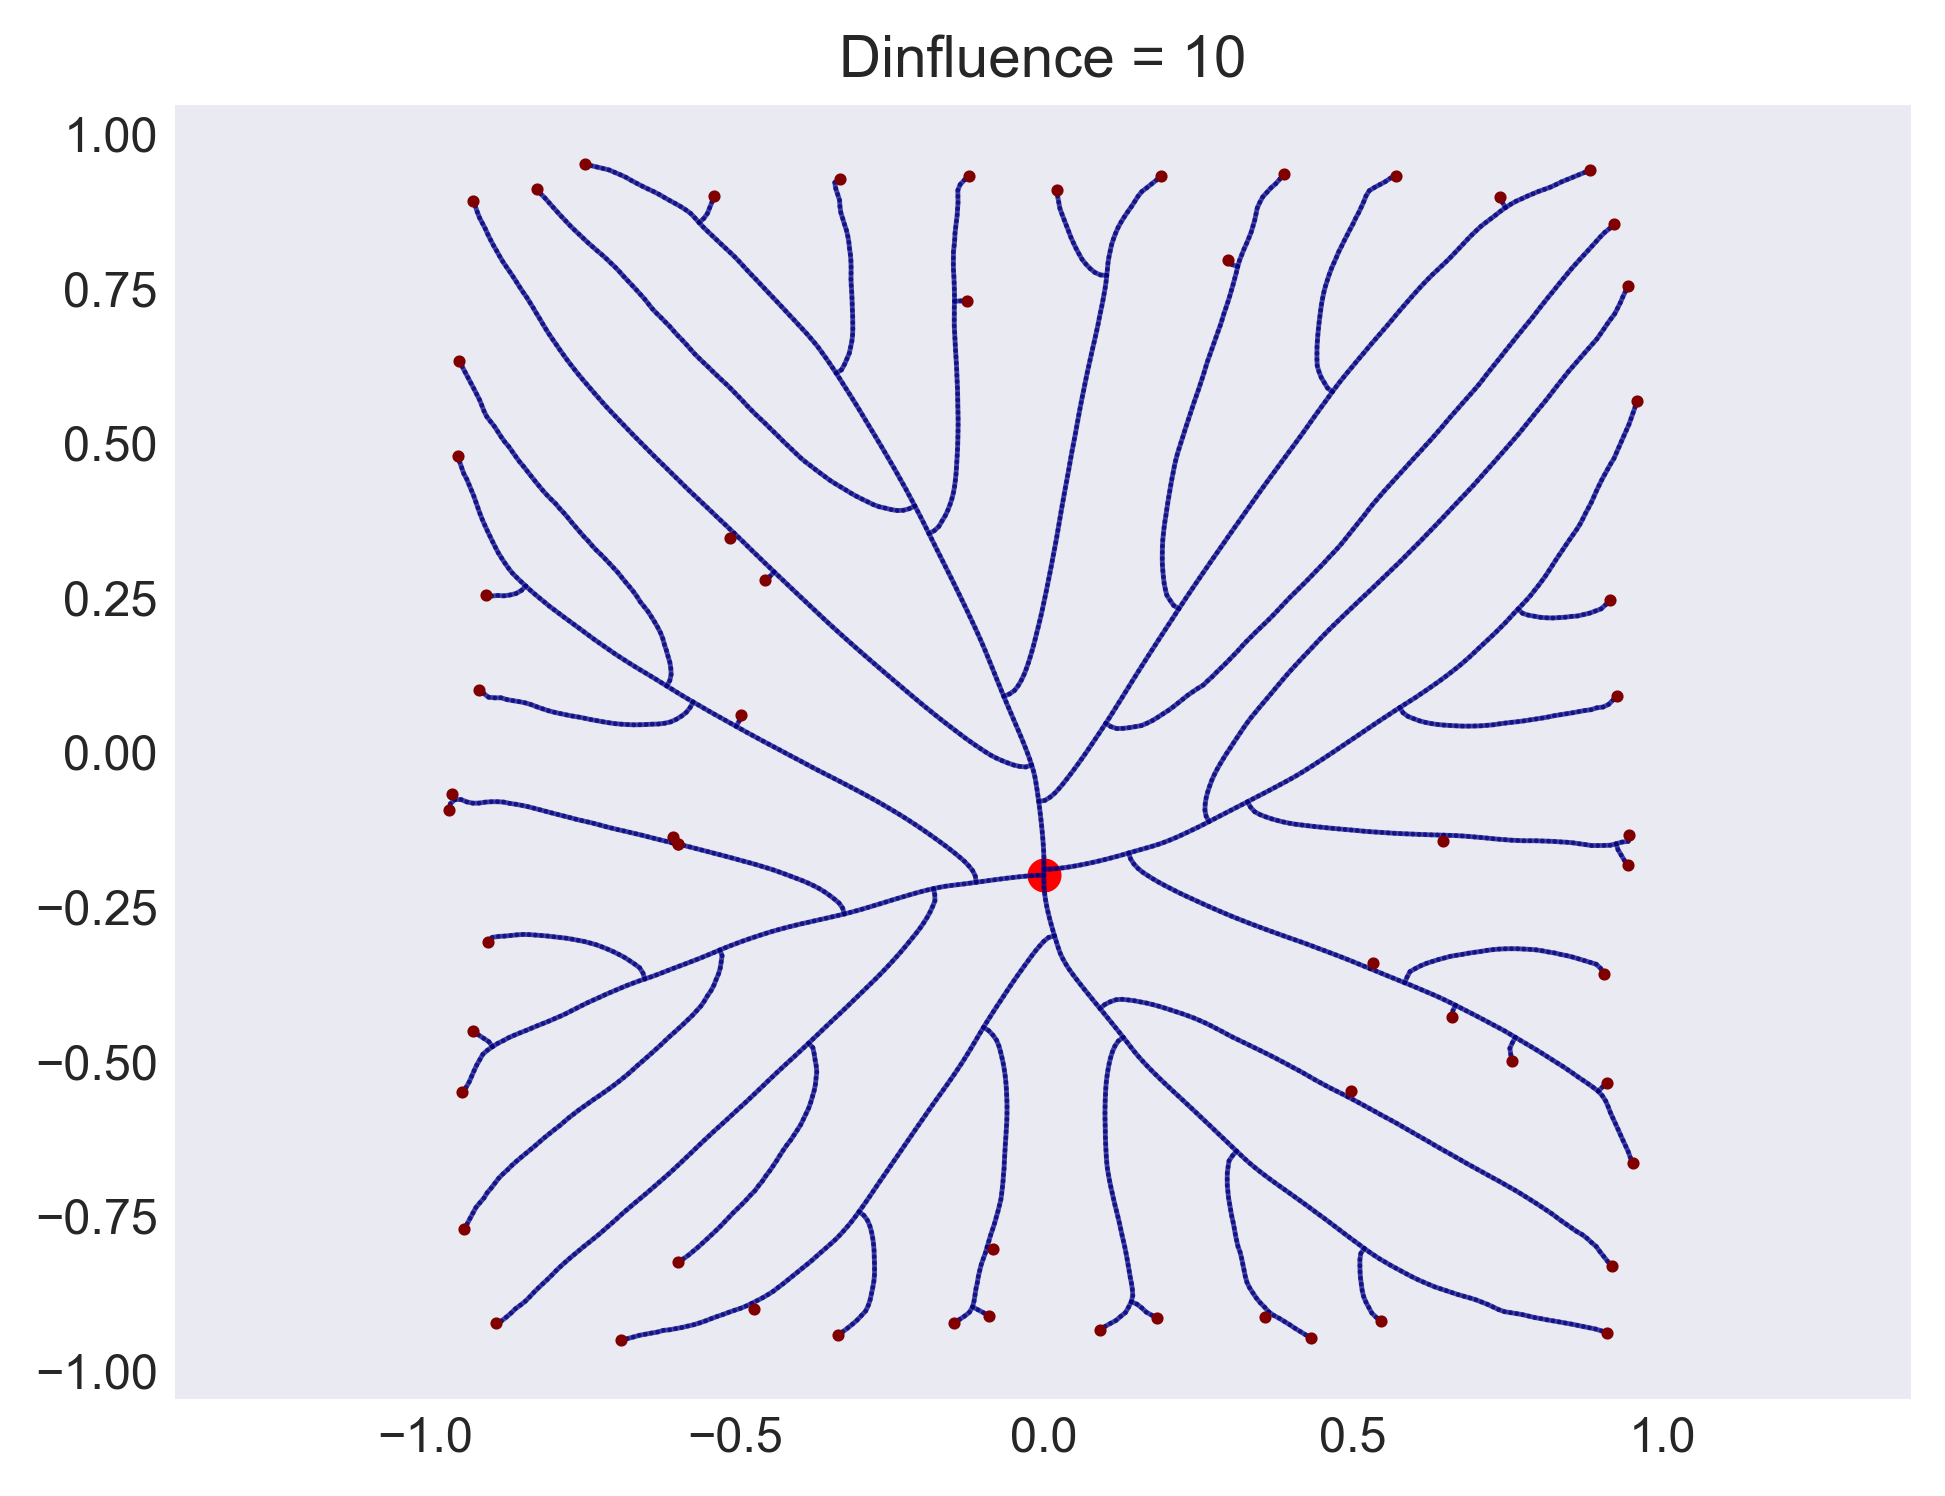

In [24]:
tree = set()
root = TreeNode([-0,-0.2], tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=1000,
                                                 Di=10,
                                                 Dg=0.01,
                                                 Dk=0.1,
                                                )
plot_tree(new_tree, root, sources, show_phase=100, show_sources=False)
plt.title('Dinfluence = 10')
len(new_tree)

In [110]:
tree = set()
root = TreeNode([-0,-0.2], tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=1000,
                                                 Di=0.25,
                                                 Dg=0.01,
                                                 Dk=0.1,
                                                )
plot_tree(new_tree, root, sources)
plt.title('Dinfluence = 0.25')

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_43487/2510616733.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 1.0, 'Dinfluence = 0.25')

  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_73449/2987353371.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 1.0, 'Dinfluence = 0.25')

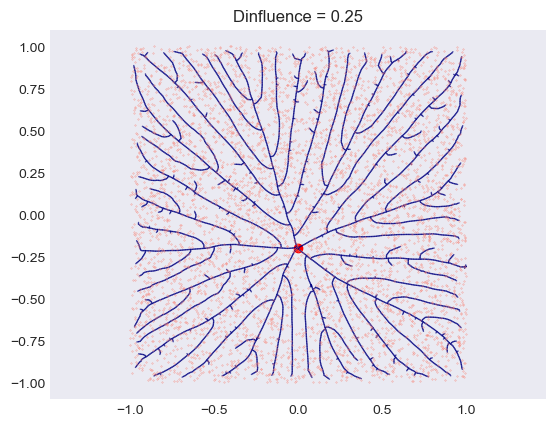

In [21]:
tree = set()
root = TreeNode([-0,-0.2], tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=1000,
                                                 Di=0.25,
                                                 Dg=0.01,
                                                 Dk=0.05,
                                                )
plot_tree(new_tree, root, sources)
plt.title('Dinfluence = 0.25')

In [25]:
tree = set()
root = TreeNode([-0,-0.2], tree=tree)
root.max_branches = 5

Di = 0.01
Dk = 0.01

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=1000,
                                                 Di=Di,
                                                 Dg=0.005,
                                                 Dk=Dk,
                                                )
plot_tree(new_tree, root, sources)
plt.title(f'Di = {Di}, Dk={Dk}')

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
len(sources), len(remaining_sources)

(5000, 0)

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_71932/2987353371.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], 'k-', lw=1, color = 'navy', alpha=0.7)


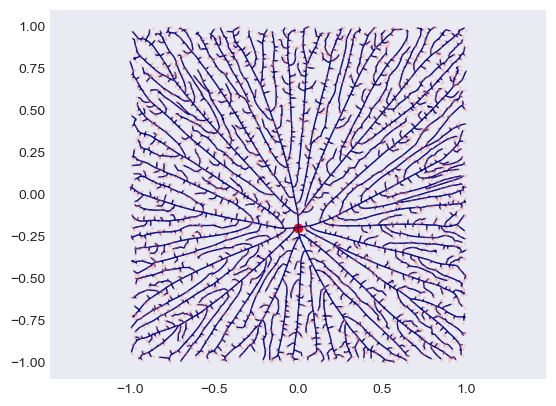

In [ ]:
plot_tree(new_tree, root, sources)

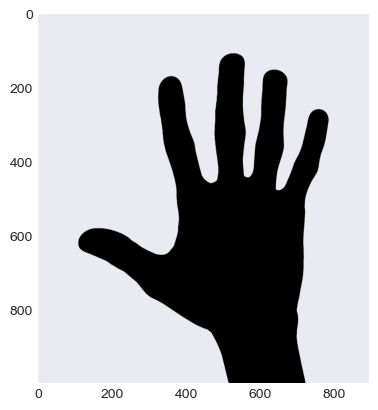

In [17]:
from PIL import Image

hand = np.array(Image.open('/Users/anyak/Documents/Lab/AstroSpace/AstroSpace-main/AstroSpace/kisspng-silhouette-drawing-clip-art-el-5b2d2dc6c127e6.0145919415296874947912.png'))
plt.imshow(hand)

In [18]:
hand_coords = []
for i in range(hand.shape[0]):
    for j in range(hand.shape[1]):
        check = hand[i][j][3] > 0
        if check == True:
            hand_coords.append(np.array((i, j)))


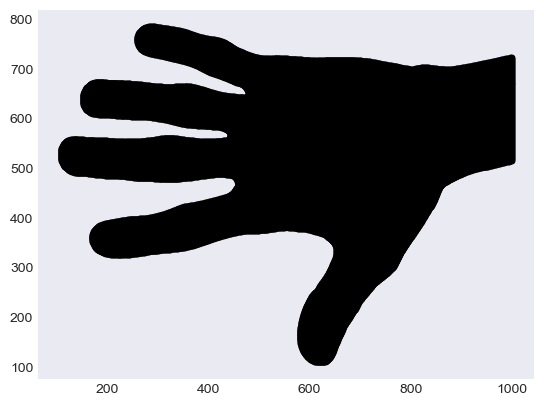

In [21]:
hand_coords = np.array(hand_coords)
plt.plot(hand_coords[:, 0], hand_coords[:, 1], '.', c='black')

In [22]:
sources = []
for i in range(5000):
    rand_item = round(np.random.uniform(0, len(hand_coords)))
    x, y = hand_coords[rand_item]
    rand_x = x + np.random.random()
    rand_y = y + np.random.random()
    sources.append(np.array([rand_x, rand_y]))

In [23]:
sources = np.array(sources)
plt.plot(sources[:, 0], sources[:, 1], '.', color='navy', ms=0.5)
plt.plot(950, 600, 'o', color='r')

  0%|          | 0/5000 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_26143/3109568029.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 1.0, 'Di=100, Dg=1, Dk=2')

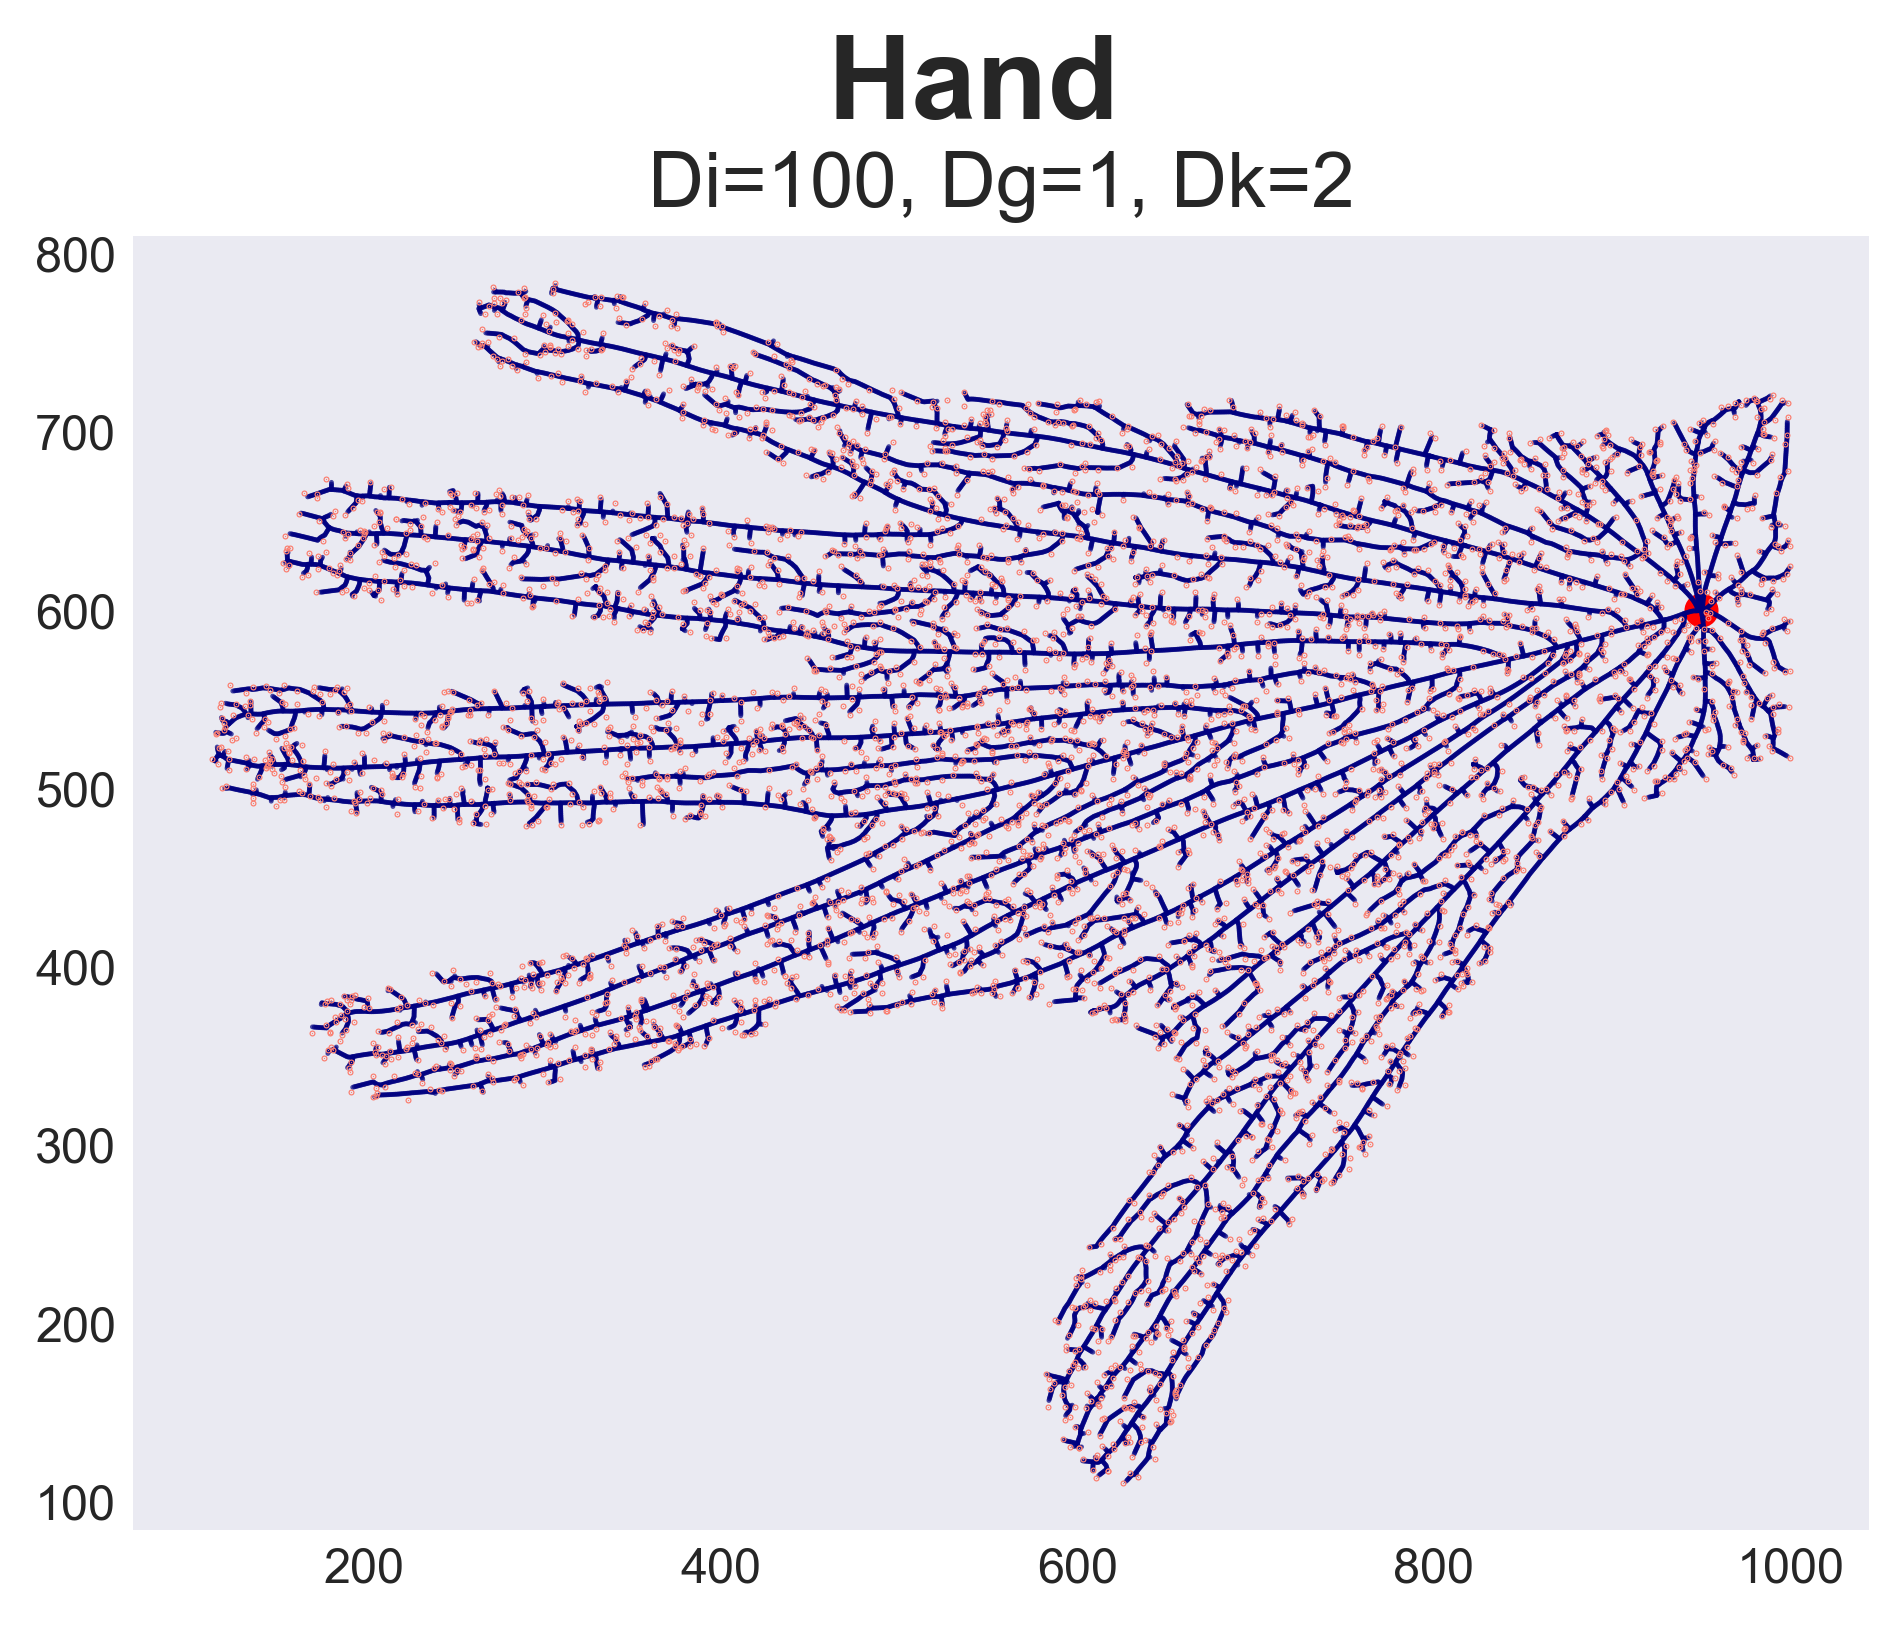

In [708]:
tree = set()
root = TreeNode([950, 600], tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=5000,
                                                 Di=100,
                                                 Dg=1,
                                                 Dk=2,
                                                )
plot_tree(new_tree, root, sources)
plt.suptitle('Hand', weight='bold',fontsize=24, y=1)
plt.title('Di=100, Dg=1, Dk=2',fontsize=16)

## Let's try NetworkX next

In [26]:
import time

In [27]:
for i in range(5):
    print(time.perf_counter())

523137.476712318
523137.476996516
523137.477004331
523137.47700844
523137.477011859


In [28]:
class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timeline():
    
    def __init__(self):
        self._start_time = None

    def new_start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")
        self._start_time = time.perf_counter()
    
    def stop(self):
        """
        Stop the timer, and report
        """
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
    
    def report(self):
        """  
        Report the elapsed time in sec
        """
        elapsed_time = time.perf_counter() - self._start_time
        return round(elapsed_time, 4)


In [29]:
t = Timeline()
t.new_start()

for i in range(5):
    time.sleep(.2)

t.report()


1.0177

In [30]:
time2D = [4.1, 4.9, 7.2,33*2]
time3D = [46.4, 49.7, 56.7, 3*60+20.5]
dinf = [10, 0.25, 0.2, 0.01]

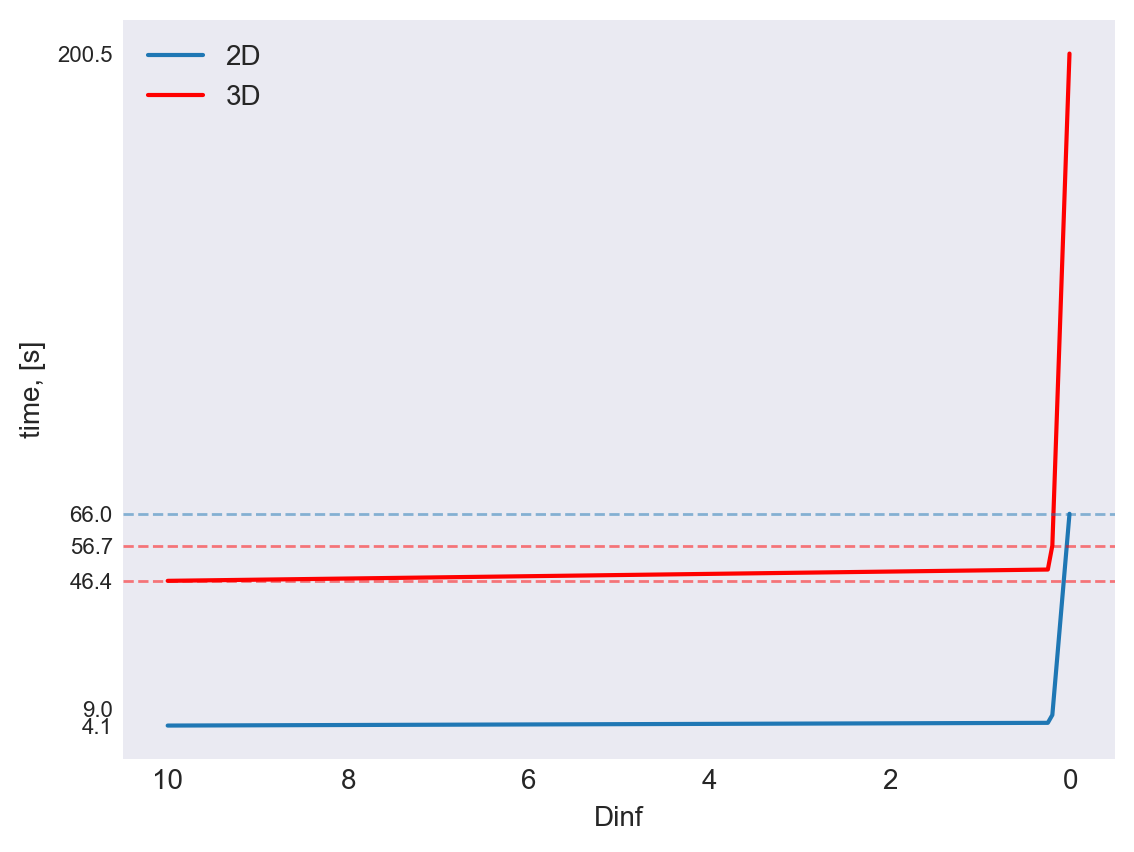

In [94]:
fig, ax = plt.subplots(1,1, dpi=200)
ax.plot(dinf, time2D, label = '2D')
ax.plot(dinf, time3D, color='r', label='3D')
plt.xlabel('Dinf')
plt.ylabel('time, [s]')
plt.legend()
plt.yticks([4.1, 9,33*2,46.4, 56.7, 3*60+20.5], size=8)

# plt.axhline(4.1, ls='--', linewidth=1, alpha=0.5)
plt.axhline(33*2, ls='--', linewidth=1, alpha=0.5)
# plt.axhline(7.2, ls='--', linewidth=1, alpha=0.5)
plt.axhline(46.4, ls='--',color='r', linewidth=1, alpha=0.5)
plt.axhline(56.7, ls='--',color='r', linewidth=1, alpha=0.5)
# plt.axhline(200.5, ls='--',color='r', linewidth=1, alpha=0.5)

# plt.axvline(10, ls='--', color='k', linewidth=1, alpha=0.5)
# plt.axvline(0.2, ls='--', color='k', linewidth=1, alpha=0.5)
# plt.axvline(0.01, ls='--', color='k', linewidth=1, alpha=0.5)

plt.gca().invert_xaxis()


# Synapses

In [25]:
class Synapse:
    def __init__(self, coords):
        self.age = 0
        self.coords = coords
        self.nodes = None
        self.alive = True
        self.mature = False
    
    def age_flag(self):
        ms = self.age + 0.5
        alpha = 1/(self.age+1)
        color = 'r'
        if self.age > 5:
            ms = 6
            alpha = 0.25
            color = 'maroon'

        kwards = {'ms': ms,
                  'color': color,
                  'alpha': alpha
        }
        return kwards

def generate_random_synapse(radius):
    coords = radius*(np.random.rand(1,2) - 0.5)[0]
    synapse = Synapse(coords)
    return synapse

In [26]:
# eprob = np.random.uniform(0,0.5)
synapses = []
slides = {}
eprob = 0
life_cycle = 15

for i in range (100):
    p = eprob
    while p <1:
        synapse = generate_random_synapse(2)
        synapses.append(synapse)
        p += np.random.uniform(0,0.5)
    
    for s in synapses:
        if s.age > life_cycle:
            s.alive = False
        s.age += 1
    synapses = list(filter(lambda x: x.alive == True, synapses))
    
    kwards = [s.age_flag() for s in synapses]
    coords = np.array([s.coords for s in synapses])
    slides[i] = {'coords': coords, 
                 'kwards': kwards}

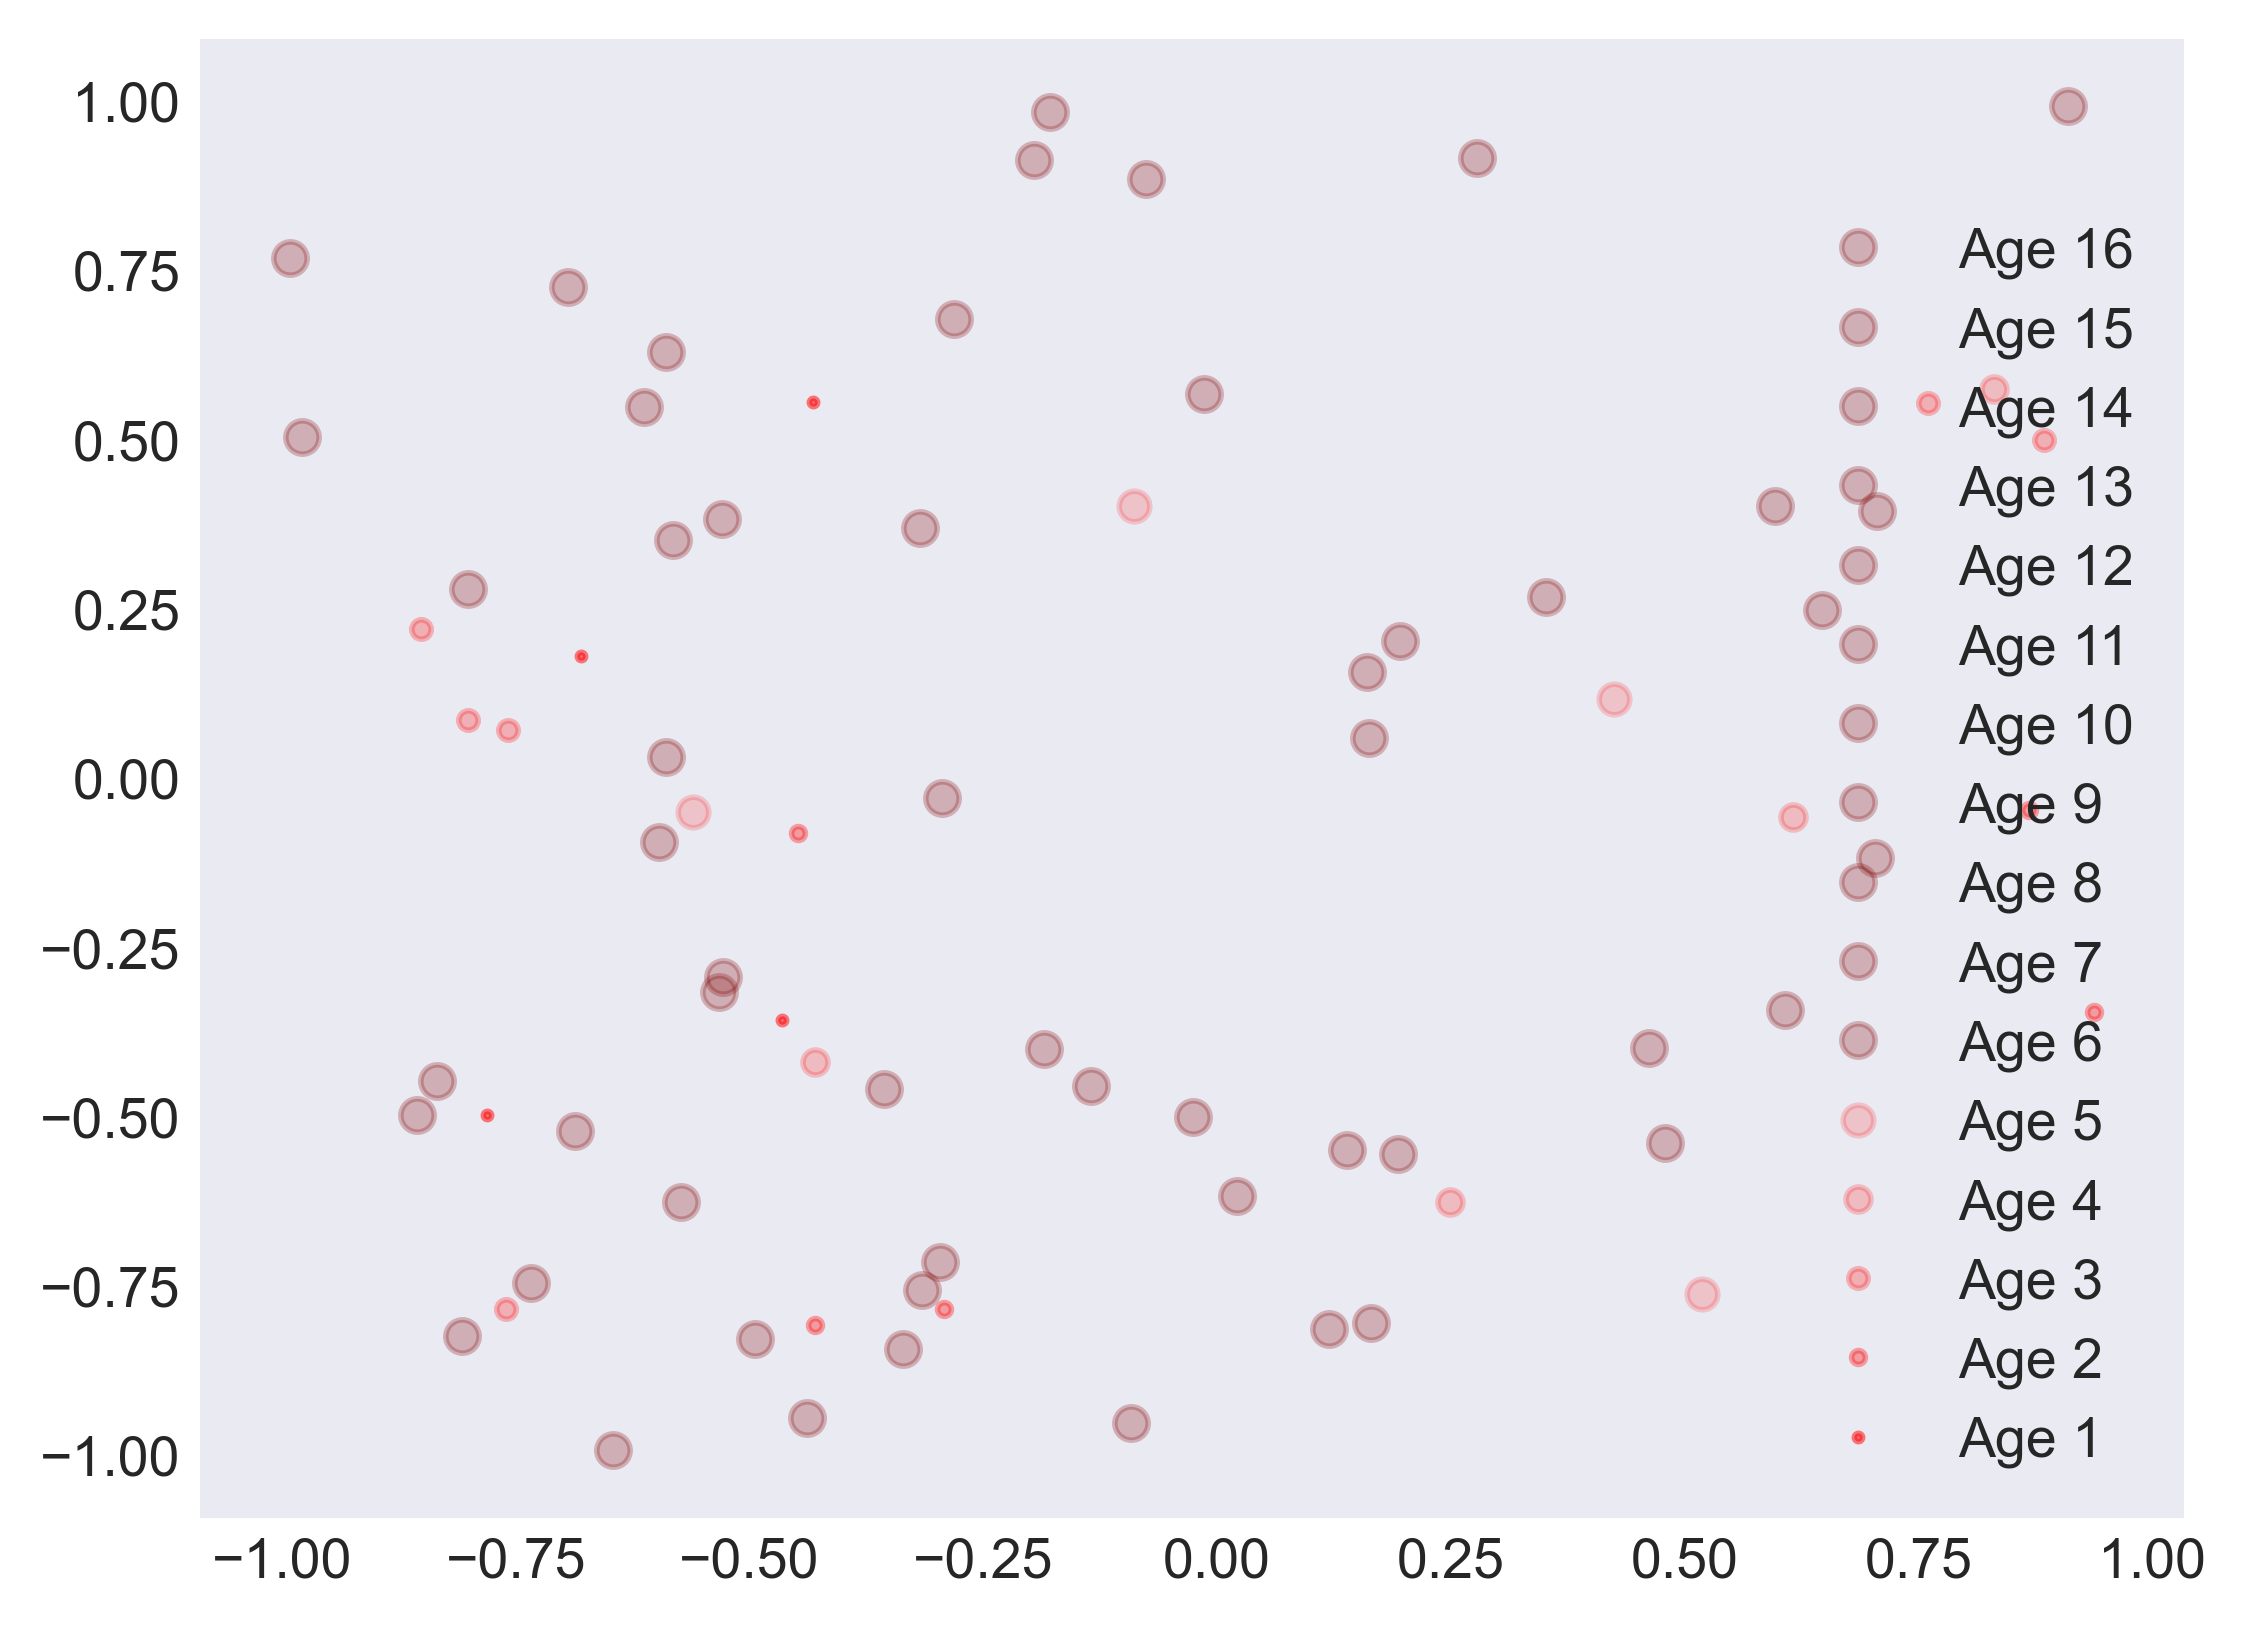

In [27]:
fig, ax = plt.subplots(1,1, dpi=400)
# syn = np.array([s.coords for s in synapses])
for s in synapses:
    x, y = s.coords
    kwards = s.age_flag()
    plt.plot(x, y, 'o', label = f'Age {s.age}', **kwards)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# plt.legend(loc= 'upper right', bbox_to_anchor=(0.65, 0.5, 0.5, 0.5))

In [36]:
# fig, ax = plt.subplots(nrows=4,ncols=4, figsize=(12, 12), dpi=300)
# for i in range(16):
#    coords = slides[i]['coords']
#    Ks = slides[i]['kwards']
#    for n,c in enumerate(coords):
#       kwards = Ks[n]
#       ax[i//4, i%4].plot(c[0], c[1], 'o', **kwards)
# fig.suptitle('Dynamic synapses', size=24)
# fig.subplots_adjust(top=0.94)

In [324]:
np.hstack([dots, np.ones((dots.shape[0],1))])

array([[ 0.19515797,  0.74120557,  1.        ],
       [-0.2140538 , -0.16150498,  1.        ],
       [ 0.71013271,  0.36445945,  1.        ],
       [ 0.74804611,  0.90769527,  1.        ],
       [ 0.98247549,  0.37923312,  1.        ]])

In [363]:

import matplotlib.animation as animation

steps = len(slides) - 1
fig, ax = plt.subplots(1,1,figsize=(12,12),dpi=300)
dots_plot = ax.scatter(np.array([]), np.array([]))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

def anim(i):
    # k = list(slides.keys())[i]
    # dots = np.array([s.coords for s in slides[k]])
    dots = slides[i]['coords']
    kwards = slides[i]['kwards']
    alphas = [k['alpha'] + 0.2 for k in kwards]
    sizes = [k['ms']*20 for k in kwards]
    
    # alphas = np.array([s.age_flag()['alpha']+0.1 for s in slides[k]])
    # sizes = np.array([s.age_flag()['ms']*15 for s in slides[k]])
    # colors = np.array([s.age_flag()['color'] for s in slides[k]])
    # dots_plot.set_data(dots[:, 0], dots[:, 1])
    dots_plot.set_offsets(np.hstack([dots, np.ones((dots.shape[0],1))]))
    dots_plot.set_alpha(alphas)
    dots_plot.set_color(c='r')
    dots_plot.set_sizes(sizes)
    # synapses = np.array([s for s in slides[k]])
    # dots_plot.set_color()

    return dots_plot

#ani = animation.FuncAnimation(fig, anim, frames=tqdm(np.arange(steps),position=0, leave=True), interval=30, blit=True, repeat=True)
ani = animation.FuncAnimation(fig, anim, frames=np.arange(steps), interval=100)
# ani.save('sample.mp4')

## Repulsion

In [28]:
# строки,  столбцы
xmax = np.max(sources[:, 0]) #round
ymax = np.max(sources[:, 1]) #round

# probability of emergence
eprob = 0.5
# lifetime
life_cycle = 15
# synapse repulsion
srep = 5
# number of possible point for new sinapse emergence around sample synapse
k = 5

In [29]:
# Poisson disc sampling using Bridson's algorithm
# see https://scipython.com/blog/poisson-disc-sampling-in-python/

# Choose up to k points around each reference point as candidates for a new
# sample point
k = 5

# Minimum distance between synapses
# repulsion
r = 5

width, height = 60, 45

# Cell side length
a = r/np.sqrt(2)
# Number of cells in the x- and y-directions of the grid
nx, ny = int(width / a) + 1, int(height / a) + 1

# A list of coordinates in the grid of cells
coords_list = [(ix, iy) for ix in range(nx) for iy in range(ny)]
# Initilalize the dictionary of cells: each key is a cell's coordinates, the
# corresponding value is the index of that cell's point's coordinates in the
# samples list (or None if the cell is empty).
cells = {coords: None for coords in coords_list}

def get_cell_coords(pt):
    """Get the coordinates of the cell that pt = (x,y) falls in."""

    return int(pt[0] // a), int(pt[1] // a)

def get_neighbours(coords):
    """Return the indexes of points in cells neighbouring cell at coords.

    For the cell at coords = (x,y), return the indexes of points in the cells
    with neighbouring coordinates illustrated below: ie those cells that could 
    contain points closer than r.

                                     ooo
                                    ooooo
                                    ooXoo
                                    ooooo
                                     ooo

    """

    dxdy = [(-1,-2),(0,-2),(1,-2),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),
            (-2,0),(-1,0),(1,0),(2,0),(-2,1),(-1,1),(0,1),(1,1),(2,1),
            (-1,2),(0,2),(1,2),(0,0)]
    neighbours = []
    for dx, dy in dxdy:
        neighbour_coords = coords[0] + dx, coords[1] + dy
        if not (0 <= neighbour_coords[0] < nx and
                0 <= neighbour_coords[1] < ny):
            # We're off the grid: no neighbours here.
            continue
        neighbour_cell = cells[neighbour_coords]
        if neighbour_cell is not None:
            # This cell is occupied: store this index of the contained point.
            neighbours.append(neighbour_cell)
    return neighbours

def point_valid(pt):
    """Is pt a valid point to emit as a sample?

    It must be no closer than r from any other point: check the cells in its
    immediate neighbourhood.

    """

    cell_coords = get_cell_coords(pt)
    for idx in get_neighbours(cell_coords):
        nearby_pt = samples[idx]
        # Squared distance between or candidate point, pt, and this nearby_pt.
        distance2 = (nearby_pt[0]-pt[0])**2 + (nearby_pt[1]-pt[1])**2
        if distance2 < r**2:
            # The points are too close, so pt is not a candidate.
            return False
    # All points tested: if we're here, pt is valid
    return True

def get_point(k, refpt):
    """Try to find a candidate point relative to refpt to emit in the sample.

    We draw up to k points from the annulus of inner radius r, outer radius 2r
    around the reference point, refpt. If none of them are suitable (because
    they're too close to existing points in the sample), return False.
    Otherwise, return the pt.

    """
    i = 0
    while i < k:
        i += 1
        rho = np.sqrt(np.random.uniform(r**2, 4 * r**2))
        theta = np.random.uniform(0, 2*np.pi)
        pt = refpt[0] + rho*np.cos(theta), refpt[1] + rho*np.sin(theta)
        if not (0 <= pt[0] < width and 0 <= pt[1] < height):
            # This point falls outside the domain, so try again.
            continue
        if point_valid(pt):
            return pt

    # We failed to find a suitable point in the vicinity of refpt.
    return False

# Pick a random point to start with.
pt = (np.random.uniform(0, width), np.random.uniform(0, height))
samples = [pt]
# Our first sample is indexed at 0 in the samples list...
cells[get_cell_coords(pt)] = 0
# ... and it is active, in the sense that we're going to look for more points
# in its neighbourhood.
active = [0]

nsamples = 1
# As long as there are points in the active list, keep trying to find samples.
while active:
    # choose a random "reference" point from the active list.
    idx = np.random.choice(active)
    refpt = samples[idx]
    # Try to pick a new point relative to the reference point.
    pt = get_point(k, refpt)
    if pt:
        # Point pt is valid: add it to the samples list and mark it as active
        samples.append(pt)
        nsamples += 1
        active.append(len(samples)-1)
        cells[get_cell_coords(pt)] = len(samples) - 1
    else:
        # We had to give up looking for valid points near refpt, so remove it
        # from the list of "active" points.
        active.remove(idx)

plt.scatter(*zip(*samples), color='r', alpha=0.6, lw=0)
# plt.xlim(0, width)
# plt.ylim(0, height)
plt.axis('off')

(-2.617190880262926, 62.21329410696806, -1.8587295465770992, 46.95686566335199)

## Tree growth

In [30]:
# нужна функция апдейта синапсов на каждом новом цикле роста дерева
def generate_synapse(tree, radius, Dk, Dg):
    coords = radius*(np.random.rand(1,2) - 0.5)[0]
    synapse = Synapse(coords)
    kdt = sp.spatial.KDTree([n.v for n in tree])
    d,inds = kdt.query(synapse.coords, distance_upper_bound=Dg*10)
    if d < Dg*10 and d > Dk:
        return synapse
    else:
        return generate_synapse(tree, radius, Dk, Dg)

def update_synapses(tree, synapses, Dk, Dg, eprob, radius=2, life_cycle=45):
    new_synapses = list(synapses)
    p = eprob

    for s in new_synapses:
        if s.age > life_cycle:
            s.alive = False
        s.age += 1

    while p <1:
        synapse = generate_synapse(tree, radius, Dk, Dg)
        if len(synapse.coords) == 0:
            continue
        new_synapses.append(synapse)
        p += np.random.uniform(0,0.5)
    
    new_synapses = list(filter(lambda x: x.alive == True, synapses))
    new_synapses = list(filter(lambda x: x.coords.shape != np.array([]).shape, synapses))
    return np.array(new_synapses)

In [31]:
def space_colonization_synupd(tree, sources, iterations=20, Dg=0.025, Di=1, Dk=0.025, upd_cycle = 50):
   
    for j in tqdm(range(iterations)):

        if j > upd_cycle:
            sources = update_synapses(tree, sources, Dk, Dg, eprob=-1)
        
        tree_prev = [n for n in tree if len(n.children) <= n.max_branches]
        
        kdt = sp.spatial.KDTree([n.v for n in tree_prev])
        
        sources_coords = [s.coords for s in sources]

        d,inds = kdt.query(sources_coords, distance_upper_bound=Di)
            
        if len(d) and np.min(d) > Di:
            d,inds = kdt.query(sources_coords, distance_upper_bound=np.min(d))
            
        for i, n in enumerate(tree_prev):
            S = sources[inds==i]
            S = [s.coords for s in S]
            n.spawn(S, Dg)
                    
        kdt2 = sp.spatial.KDTree([n.v for n in tree])
        too_close = kdt2.query_ball_point(sources_coords, Dk, return_length=True)        
        sources = sources[too_close == 0] 
        
        if not len(sources):
            break
        
        # add small jitter to break up ties
        for s in sources:
            s.coords = s.coords + np.random.randn(*s.coords.shape)*Dg*0.05

    return tree, sources

  0%|          | 0/1500 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_47099/3861798080.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 1.0, 'Di=1, Dg=0.005, Dk=0.01, iteration=1500, points=500')

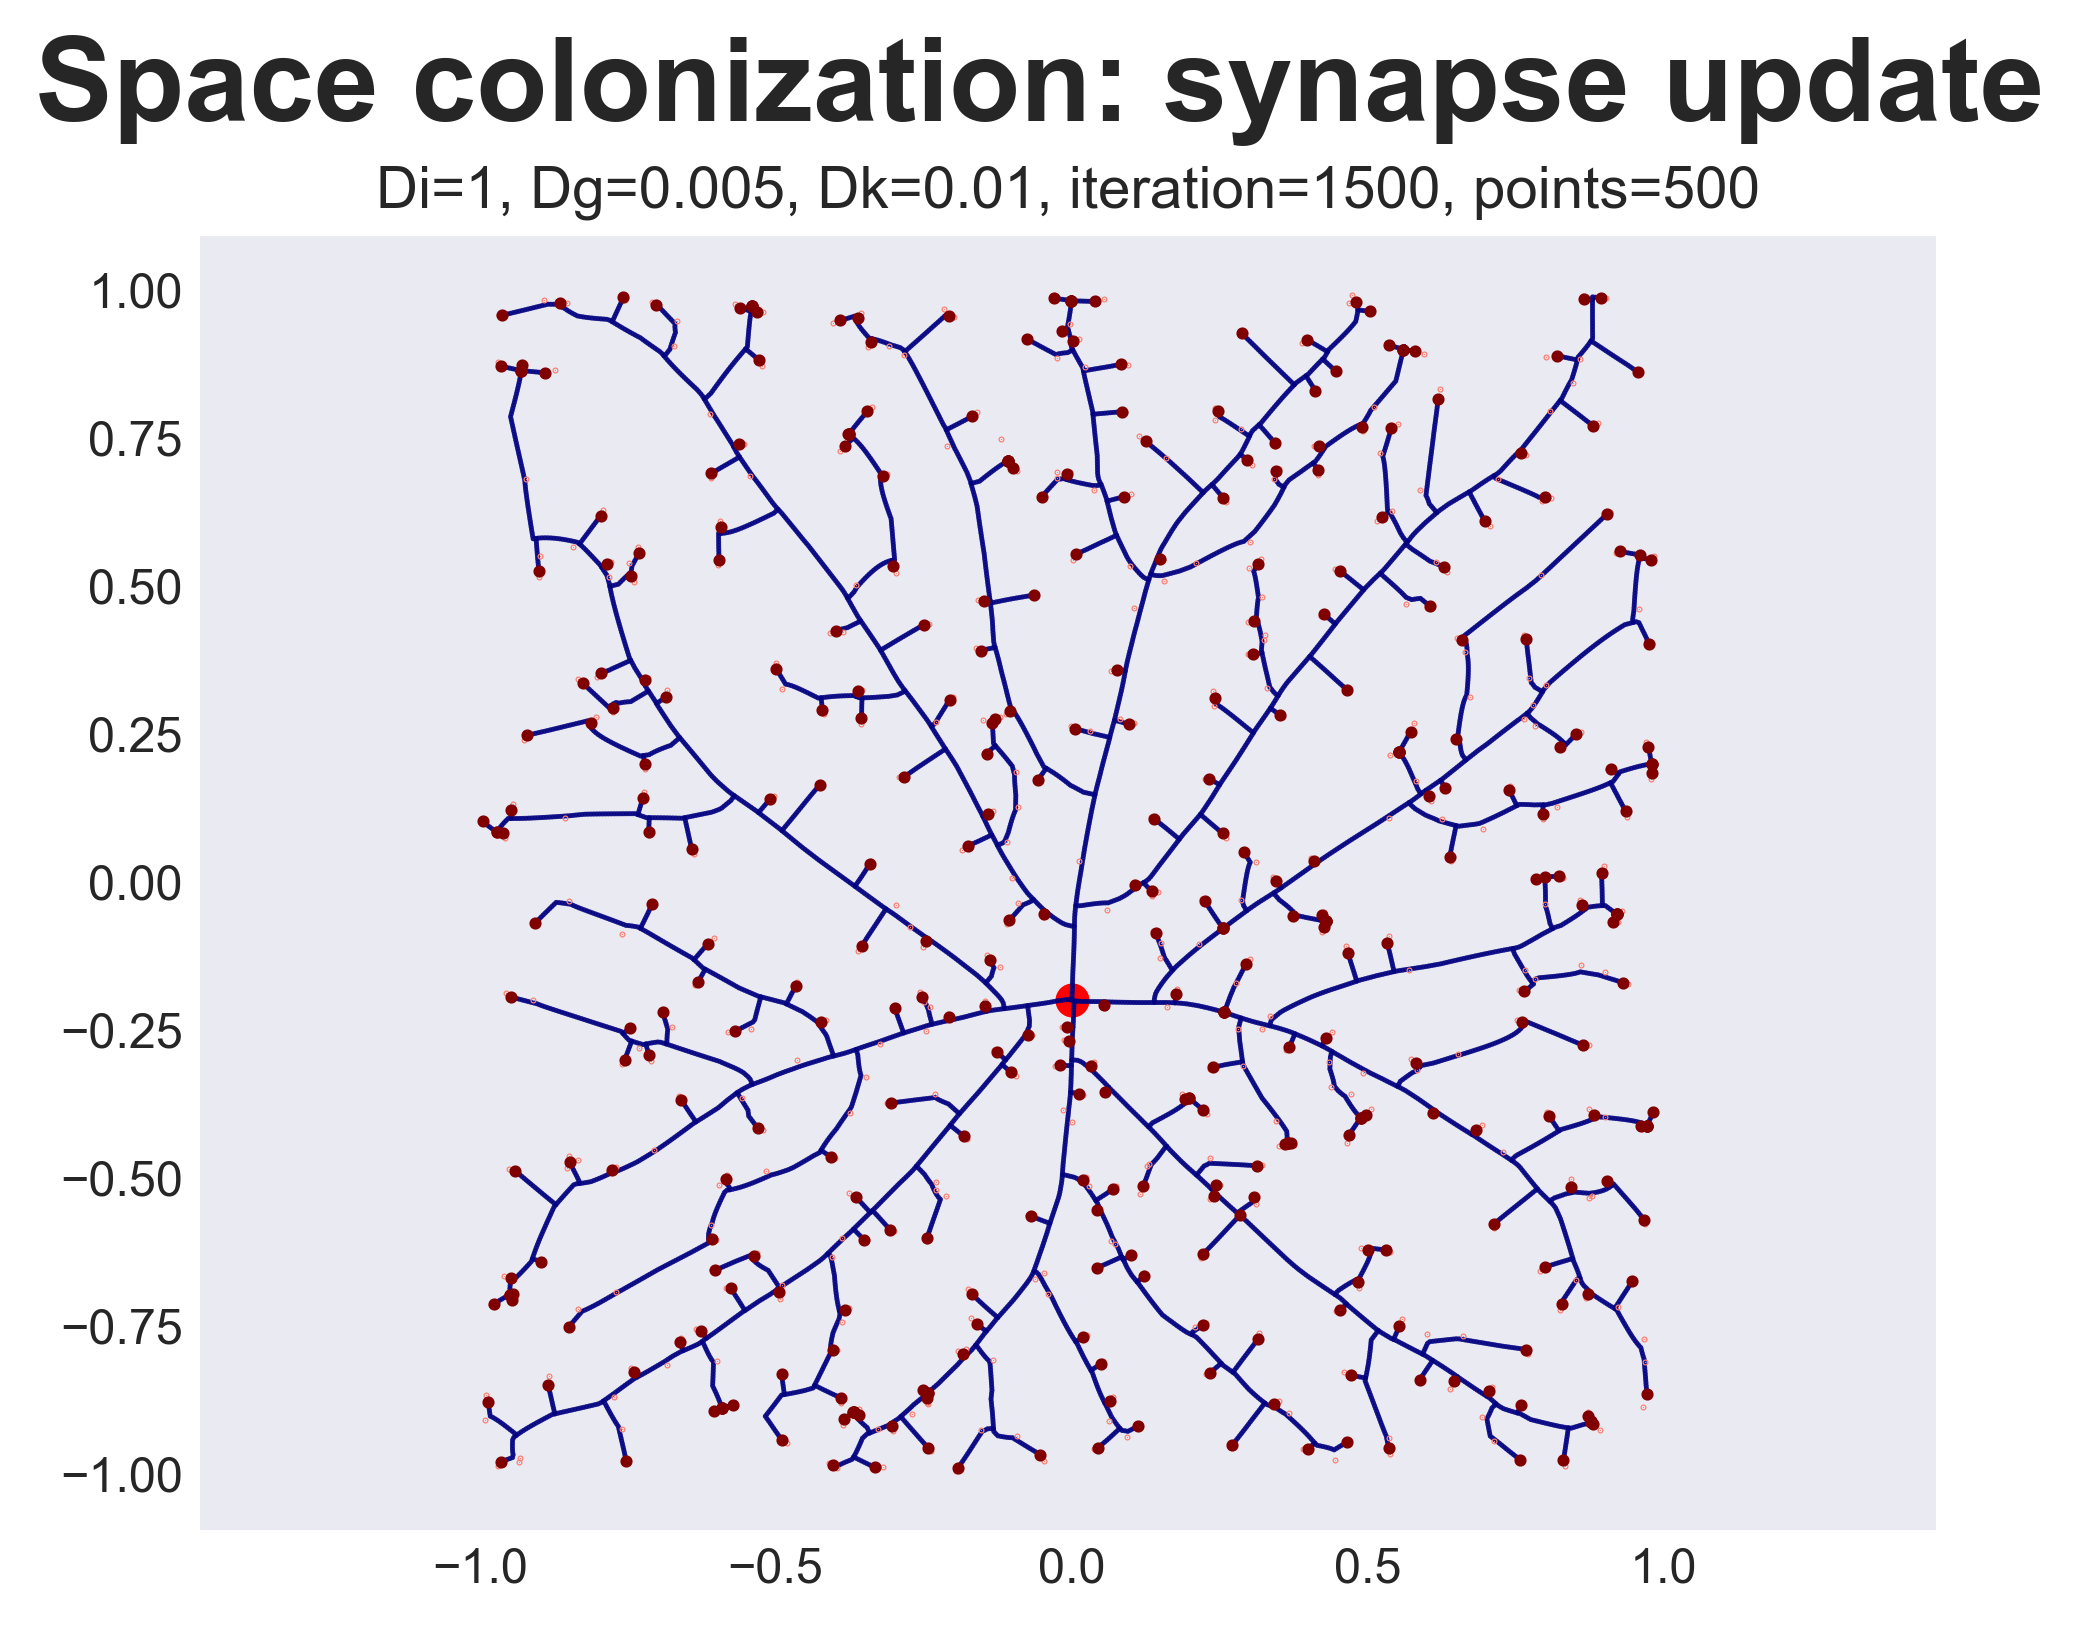

In [32]:
life_cycle = 45
Npoints = 500
sources = 2*(np.random.rand(Npoints,2) - 0.5)
sources_syn = np.array([Synapse(s) for s in sources])
for ss in sources_syn:
    ss.age = -50
tree = set()
root = TreeNode([-0,-0.2], tree=tree)

new_tree_syn, remaining_sources = space_colonization_synupd(tree, sources_syn, 
                                                 iterations=1500,
                                                 Di=1,
                                                 Dg=0.005,
                                                 Dk=0.01,
                                                 upd_cycle=50
                                                )
plot_tree(new_tree_syn, root, sources, show_phase=45)
plt.suptitle('Space colonization: synapse update', weight='bold',fontsize=24, y=1)
plt.title('Di=1, Dg=0.005, Dk=0.01, iteration=1500, points=500',fontsize=12)

  0%|          | 0/1500 [00:00<?, ?it/s]

/var/folders/gt/8b29lvnj5pv_r0437cp0b0mc0000gn/T/ipykernel_47099/3861798080.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plot(vx[:,0], vx[:,1], 'k-', lw=1, color = 'navy', alpha=0.7)


Text(0.5, 1.0, 'Di=1, Dg=0.005, Dk=0.01, iteration=1500, points=500')

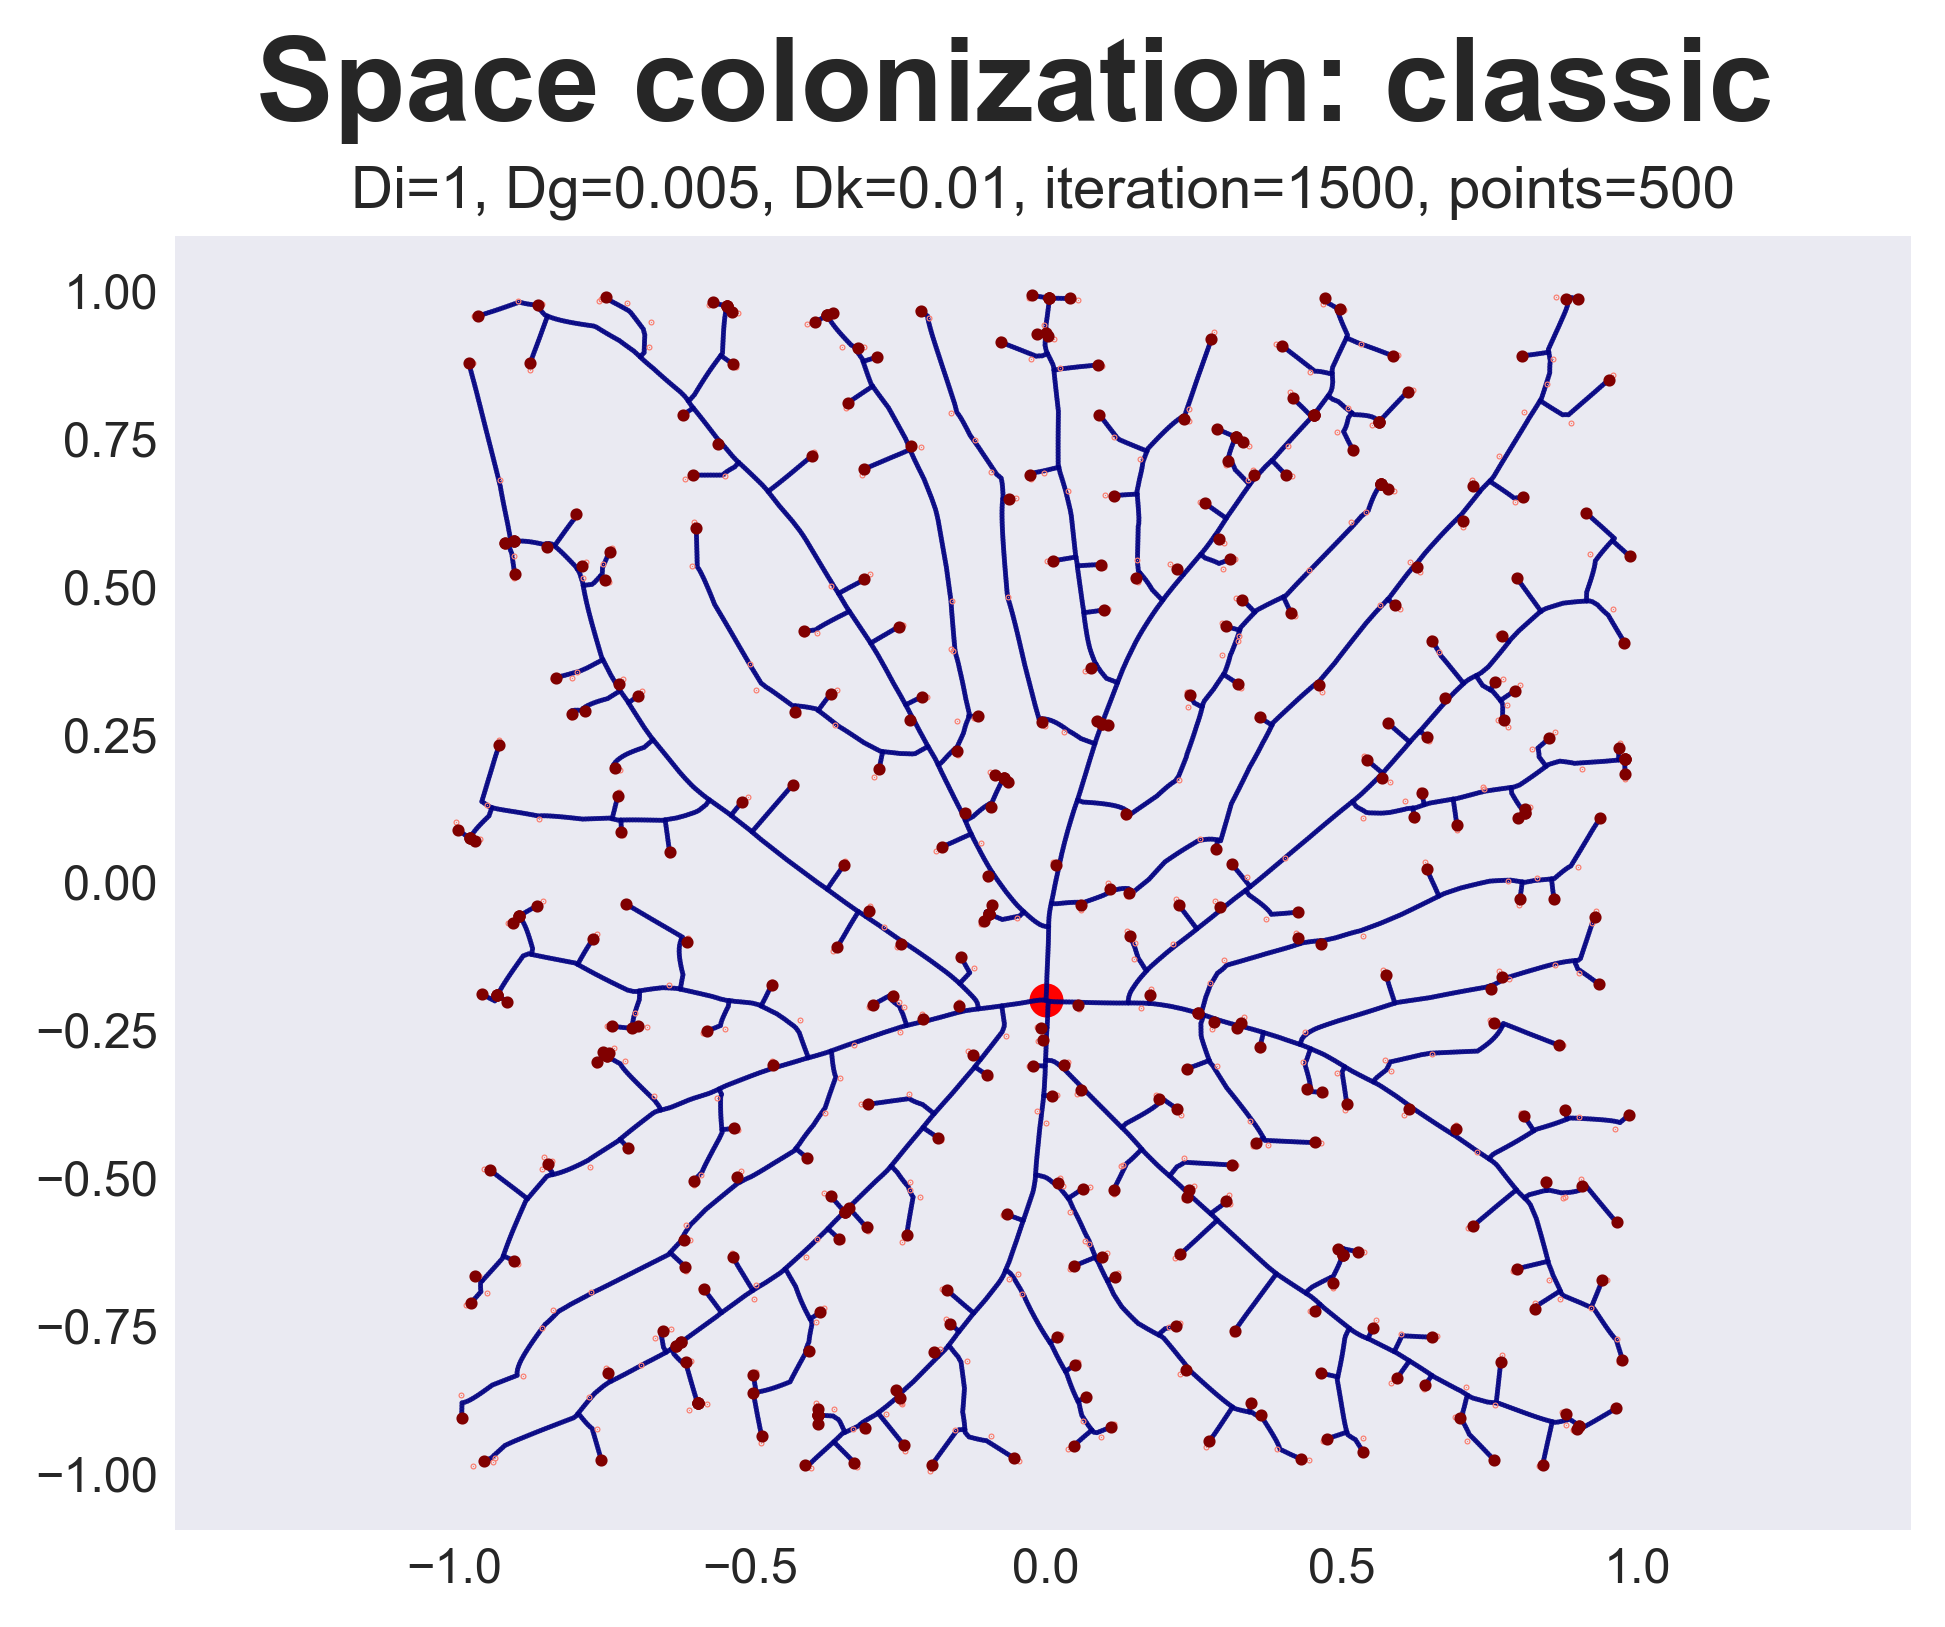

In [33]:
tree = set()
root = TreeNode([-0,-0.2], tree=tree)

new_tree, remaining_sources = space_colonization(tree, sources, 
                                                 iterations=1500,
                                                 Di=1,
                                                 Dg=0.005,
                                                 Dk=0.01,
                                                )
plot_tree(new_tree, root, sources)
plt.suptitle('Space colonization: classic', weight='bold',fontsize=24, y=1)
plt.title('Di=1, Dg=0.005, Dk=0.01, iteration=1500, points=500',fontsize=12)

In [56]:
import networkx as nx
def tree_to_graph(tree, optimize_graph=False):
    def get_node(node):
        '''
        represent node as tuple
        '''
        v = node.v
        return tuple(v)
    root = [i for i in tree if i.parent == None][0]
    graph = nx.DiGraph()
    segms = [(get_node(node.parent), get_node(node)) for node in tree if node != root]
    children = root.children
    root_connect = [(get_node(root), get_node(child)) for child in children]
    graph.add_node(get_node(root), root = get_node(root))
    graph.add_nodes_from([get_node(node) for node in tree if node != root], root = get_node(root))
    graph.add_edges_from(segms)
    graph.add_edges_from(root_connect)

    return graph

In [57]:
graph_synupd = tree_to_graph(new_tree_syn)
graph_classic = tree_to_graph(new_tree)

In [65]:
len(graph_classic)

7045

In [59]:
save_path_graph = '/Users/anyak/Documents/Lab/astrocyte graphs/SCA graphs'

# SWC

In [60]:
import sys
sys.path.insert(1, '/Users/anyak/Documents/Lab/SWC/astroTanya')
sys.path.insert(1, '/Users/anyak/Documents/Lab/neuro.im-proc')
import astrobject
from astrobject import ascii, Table

import tmd 
from tmd.view import view, plot
import morphio 
import neurom as nm
from neurom.view import matplotlib_impl, matplotlib_utils

In [61]:
save_path_swc = '/Users/anyak/Documents/Lab/SWC/SCA_swc'

In [64]:
# obj_synupd = astrobject.AG(graph_synupd).swc()
obj_classic = astrobject.AG(graph_classic).swc(center=(0.0, -0.2))

  0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
#params
name = ['synupd lifecycle 50', 'classic lifecycle 50']
ratio=(1, 1, 1)
cell_type = 7
filename = save_path_swc + f'/{name[0]}.swc'

In [67]:
def swc_save(data, cell_type, filename, ratio=None, sigmas_rad = False, sigmas_vals = None):
    astro = data
    lines = []
    keys = ['#index', 'type ', 'X ', 'Y ', 'Z ', 'radius ', 'parent', '\n']
    soma = 1
    radius = 0.125

    data = Table()
    # ratio = ratio if ratio else self.ratio

    X = []
    Y = []
    # Z = []
    POS = []
    PAR = []

    for r in astro:
        for n in r.items():
            x, y = n[0]
            X.append(x)
            Y.append(y)
            # Z.append(z)
            pos, par = n[1]
            POS.append(pos)
            PAR.append(par)

    ntype = np.full(len(POS), cell_type)
    ntype[0] = 1
    
    if sigmas_rad == True:
        
        if sigmas_vals == None:
            print('Add sigmas values')
            
        radius = [radius]
        filename = out + f'/{name}_rads.swc'
        
        for z in list(zip(X, Y, Z))[1:]:
            #  половина сигмы --- радиус
            radius.append((sigmas_vals[z])/2)
        radius = np.array(radius)

    data['#index'] = np.array(POS)
    data['type'] = ntype
    data['X'] = np.array(X) * ratio[0]
    data['Y'] = np.array(Y) * ratio[1]
    data['Z'] = np.array(Z) * ratio[2]
    data['radius'] = radius
    data['parent'] = np.array(PAR)

    data.write(filename, format='ascii', overwrite=True)

In [68]:
swc_save(obj_classic, cell_type=cell_type, filename=filename, ratio = ratio)

In [69]:
cell = tmd.io.load_neuron(filename, remove_duplicates=True)


LoadNeuronError: Cannot create connectivity, nodes not connected correctly.

In [ ]:
view.neuron(cell, nosoma=True, diameter=False)

In [ ]:
ph_astro = tmd.methods.get_ph_neuron(cell)

In [ ]:
plot.diagram(ph_astro, subplot=True)
# plt.savefig('diagram.png', dpi=300)

plot.barcode(ph_astro, subplot=True)
# plt.savefig('barcode.png', dpi=300)

plot.persistence_image(ph_astro, subplot=True)
# plt.savefig('persistence_image.png', dpi=300)